In [64]:
%config Completer.use_jedi = False

import os
import platform
from collections import namedtuple
import time

# import tqdm
import pandas as pd
import numpy as np
import sparse

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import _LRScheduler
# from torchvision import transforms
# from torchsummary import summary
# from efficientnet_pytorch_3d import EfficientNet3D
from my_efficientnet_pytorch_3d import EfficientNet3D
import torchio

from utils import CTDataset


########################

RUNNING_IN_KAGGLE = 'linux' in platform.platform().lower()
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/" if RUNNING_IN_KAGGLE else 'data/'
PROCESSED_PATH = 'FIX IT!' if RUNNING_IN_KAGGLE else 'data/processed-data/'  # TODO: fix this line

dtype = torch.float32
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
device = torch.device(device)

In [13]:
import itertools

from tqdm.notebook import tqdm

In [3]:
train_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=True,
    transform=transforms,
    test_size=0.25,
    padding_mode='edge',
    random_state=42,
    pad_global=False,
)

test_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=False,
    transform=transforms,
    test_size=0.25,
    padding_mode='edge',
    random_state=42,
    pad_global=False,
)

In [41]:
FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238

def normalize_data(data):
    weeks, FVCs, features, masks, images = data

    weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002

    weeks = (weeks.numpy() - weeks_mean) / weeks_std
    FVCs = (FVCs.numpy() - FVCs_mean) / FVCs_std
    features = features.type(dtype).numpy()

    return weeks, FVCs, features

In [58]:
X_train = []
y_train = []

for data in tqdm(train_dataset):
    weeks, FVCs, features = normalize_data(data)
    weeks_weeks_FVCs, y_local = zip(*[([a, b, c], d) for (a, b), (c, d) in
                                      itertools.product(zip(weeks, FVCs), zip(weeks, FVCs))])
    features = np.tile(features, (len(weeks) ** 2, 1))
    X_train_local = np.hstack([features, weeks_weeks_FVCs])

    X_train.append(X_train_local)
    y_train.append(np.array(y_local) * FVCs_std + FVCs_mean)

X_train = np.vstack(X_train)
y_train = np.hstack(y_train)

In [67]:
X_train, y_train = X, y_train

In [66]:
X_test = []
y_test = []

for data in tqdm(test_dataset):
    weeks, FVCs, features = normalize_data(data)
    weeks_weeks_FVCs, y_local = zip(*[([a, b, c], d) for (a, b), (c, d) in
                                      itertools.product(zip(weeks, FVCs), zip(weeks, FVCs))])
    features = np.tile(features, (len(weeks) ** 2, 1))
    X_test_local = np.hstack([features, weeks_weeks_FVCs])

    X_test.append(X_test_local)
    y_test.append(np.array(y_local) * FVCs_std + FVCs_mean)

X_test = np.vstack(X_test)
y_test = np.hstack(y_test)

In [60]:
X.shape, y.shape

((15498, 15), (15498,))

In [72]:
def metric_laplace(y_preds, y_true, sigma=70):
    abs_diff = np.abs(y_preds - y_true)
    abs_diff = np.clip(abs_diff, 0, 1000)
    sigma = np.clip(sigma, 0, 70)
    metrics = np.sqrt(2) * abs_diff / sigma + np.log(sigma) + np.log(2) / 2
    return metrics.mean()

In [62]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

In [81]:
lasso = Lasso(alpha=1e-2)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
lasso_train_preds = lasso.predict(X_train)
metric_laplace(lasso_train_preds, y_train), metric_laplace(lasso_preds, y_test)

(7.700430138672375, 7.642074328549873)

In [81]:
ridge = Ridge(alpha=1e-2)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)
ridge_train_preds = ridge.predict(X_train)
metric_laplace(ridge_train_preds, y_train), metric_laplace(ridge_preds, y_test)

(7.700430138672375, 7.642074328549873)

In [82]:
gb = GradientBoostingRegressor(loss='huber', n_estimators=1000, subsample=0.3, verbose=1)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)
gb_train_preds = gb.predict(X_train)
metric_laplace(gb_train_preds, y_train), metric_laplace(gb_preds, y_test)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1      266261.5457       52377.5982           10.02s
         2      228689.1850       46294.3019            9.50s
         3      188641.0147       37361.1874            8.97s
         4      162826.4940       30742.2041            8.72s
         5      135726.9044       25016.0284            8.76s
         6      118304.6997       20005.2057            8.61s
         7      101257.3374       16196.7410            8.52s
         8       83887.1447       13434.5286            8.56s
         9       75522.3624       11384.1294            8.48s
        10       64968.0237        8821.7945            8.42s
        20       27288.6207        1598.4531            8.09s
        30       21247.2311         296.7783            7.99s
        40       18755.8008         139.5506            7.97s
        50       17475.1245          88.5543            7.90s
        60       16739.0639          65.6132            7.86s
       

(6.24474639550477, 9.091413952263828)

In [85]:
import xgboost as xgb
from xgboost import XGBRegressor

In [98]:
def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' Root mean squared log error metric.'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

In [105]:
def xgb_laplace_metric(predt: np.ndarray, dtrain: xgb.DMatrix):
    ''' '''
    y = dtrain.get_label()
    return 'PyLoss', metric_laplace(predt, y)
#     elements = np.power(np.log1p(y) - np.log1p(predt), 2)
#     return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

In [ ]:
xgb.train()

In [117]:
model = XGBRegressor(n_estimators=1000)
model.fit(X_train[:100], y_train[:100], eval_metric=xgb_laplace_metric,
          eval_set=[(X_test, y_test), (X_train[:100], y_train[:100])], verbose=True)
# , eval_metric="error", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:2111.60205	validation_1-rmse:1524.32483	validation_0-PyLoss:24.29833	validation_1-PyLoss:24.79812
[1]	validation_0-rmse:1706.86609	validation_1-rmse:1080.42285	validation_0-PyLoss:22.57537	validation_1-PyLoss:23.61615
[2]	validation_0-rmse:1428.75464	validation_1-rmse:767.67883	validation_0-PyLoss:20.25315	validation_1-PyLoss:19.75658
[3]	validation_0-rmse:1249.28503	validation_1-rmse:547.06921	validation_0-PyLoss:18.63108	validation_1-PyLoss:15.38518
[4]	validation_0-rmse:1133.64917	validation_1-rmse:389.93881	validation_0-PyLoss:17.40064	validation_1-PyLoss:12.24748
[5]	validation_0-rmse:1058.64880	validation_1-rmse:278.43893	validation_0-PyLoss:16.69946	validation_1-PyLoss:10.04205
[6]	validation_0-rmse:1009.09522	validation_1-rmse:199.13901	validation_0-PyLoss:16.35030	validation_1-PyLoss:8.47372
[7]	validation_0-rmse:976.50977	validation_1-rmse:142.47481	validation_0-PyLoss:16.13661	validation_1-PyLoss:7.36444
[8]	validation_0-rmse:955.02954	validation_1-rmse

[71]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[72]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[73]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[74]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[75]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[76]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[77]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[78]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[79]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-

[142]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[143]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[144]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[145]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[146]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[147]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[148]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[149]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[150]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[213]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[214]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[215]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[216]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[217]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[218]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[219]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[220]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[221]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[284]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[285]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[286]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[287]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[288]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[289]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[290]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[291]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[292]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[355]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[356]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[357]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[358]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[359]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[360]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[361]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[362]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[363]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[426]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[427]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[428]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[429]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[430]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[431]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[432]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[433]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[434]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[497]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[498]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[499]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[500]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[501]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[502]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[503]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[504]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[505]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[568]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[569]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[570]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[571]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[572]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[573]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[574]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[575]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[576]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[639]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[640]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[641]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[642]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[643]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[644]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[645]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[646]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[647]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[710]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[711]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[712]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[713]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[714]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[715]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[716]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[717]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[718]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[781]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[782]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[783]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[784]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[785]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[786]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[787]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[788]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[789]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[852]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[853]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[854]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[855]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[856]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[857]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[858]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[859]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[860]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[923]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[924]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[925]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[926]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[927]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[928]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[929]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[930]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[931]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	vali

[994]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[995]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[996]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[997]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[998]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508
[999]	validation_0-rmse:908.85736	validation_1-rmse:0.00040	validation_0-PyLoss:15.77914	validation_1-PyLoss:4.59508


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [132]:
model = XGBRegressor(n_estimators=12)
model.fit(X_train, y_train, eval_metric=xgb_laplace_metric,
          eval_set=[(X_test, y_test), (X_train, y_train)], verbose=True)
# , eval_metric="error", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:1903.45374	validation_1-rmse:2021.73193	validation_0-PyLoss:24.59586	validation_1-PyLoss:24.66782
[1]	validation_0-rmse:1337.03064	validation_1-rmse:1424.81348	validation_0-PyLoss:23.35425	validation_1-PyLoss:23.85805
[2]	validation_0-rmse:949.12268	validation_1-rmse:1009.11426	validation_0-PyLoss:20.35093	validation_1-PyLoss:21.45843
[3]	validation_0-rmse:679.28509	validation_1-rmse:720.96356	validation_0-PyLoss:16.50493	validation_1-PyLoss:17.64494
[4]	validation_0-rmse:501.03708	validation_1-rmse:522.63629	validation_0-PyLoss:13.13218	validation_1-PyLoss:14.06476
[5]	validation_0-rmse:390.53622	validation_1-rmse:388.85571	validation_0-PyLoss:10.92609	validation_1-PyLoss:11.43444
[6]	validation_0-rmse:323.44617	validation_1-rmse:299.45447	validation_0-PyLoss:9.57366	validation_1-PyLoss:9.67866
[7]	validation_0-rmse:281.92471	validation_1-rmse:242.39963	validation_0-PyLoss:8.79170	validation_1-PyLoss:8.53086
[8]	validation_0-rmse:262.89365	validation_1-rmse:206.0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=12, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [133]:
model.feature_importances_

array([0.010345  , 0.00730107, 0.00966452, 0.01028113, 0.        ,
       0.00157708, 0.00740865, 0.01192133, 0.        , 0.00561325,
       0.03200223, 0.00938955, 0.00716583, 0.8813432 , 0.00598721],
      dtype=float32)

In [124]:
preds = model.predict(X_test)
metric_laplace(preds, y_test)

9.040723648743892

In [127]:
preds = model.predict(X_train)
metric_laplace(preds, y_train)

4.66529457807553

In [130]:
np.mean(np.abs(preds - y_train))

3.4759970721713587

In [122]:
np.log(70) + np.log(2) / 2

4.595068832329332

In [120]:
y_train[:100]

array([2390., 2390., 2322., 2305., 2116., 2036., 2062., 1865., 1928.,
       1901., 2322., 2390., 2390., 2322., 2305., 2116., 2036., 2062.,
       1865., 1928., 1901., 2322., 2390., 2390., 2322., 2305., 2116.,
       2036., 2062., 1865., 1928., 1901., 2322., 2390., 2390., 2322.,
       2305., 2116., 2036., 2062., 1865., 1928., 1901., 2322., 2390.,
       2390., 2322., 2305., 2116., 2036., 2062., 1865., 1928., 1901.,
       2322., 2390., 2390., 2322., 2305., 2116., 2036., 2062., 1865.,
       1928., 1901., 2322., 2390., 2390., 2322., 2305., 2116., 2036.,
       2062., 1865., 1928., 1901., 2322., 2390., 2390., 2322., 2305.,
       2116., 2036., 2062., 1865., 1928., 1901., 2322., 2390., 2390.,
       2322., 2305., 2116., 2036., 2062., 1865., 1928., 1901., 2322.,
       2390.])

In [ ]:
xgb.train({'tree_method': 'hist', 'seed': 1994,
           'disable_default_eval_metric': 1},
          dtrain=dtrain,
          num_boost_round=10,
          obj=squared_log,
          feval=rmsle,
          evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
          evals_result=results)

In [ ]:
def forward(self, data):
    weeks, FVCs, features, lungs, images = self._normalize_data(data)
#         lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - data.masks) + data.masks * data.images
#         lungs = (lungs - lungs_mean) / lungs_std
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         OSICNet._normalize_data(data)

#         lungs = data.masks

    ###############################
#         lungs = lungs.unsqueeze(0).to(self.device)  # TODO: uncomment
#         lungs_features = self.CT_features_extractor(lungs)
    ###############################

#         weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
#         FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
#         other_ftrs_mean = np.array([
#             2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
#             -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
#             2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
#         ])
#         other_ftrs_std = np.array([
#             2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
#             1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
#             4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
#         ])

#         data._replace(weeks = (np.array(data.weeks) - weeks_mean) / weeks_std)
#         data._replace(fvcs = (np.array(data.fvcs) - FVCs_mean) / FVCs_std)
#         data._replace(features = (np.array(data.features) - other_ftrs_mean) / other_ftrs_std)

#         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
#         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
#         weeks[:, 3] = 1
#         weeks[:, 2] = data_weeks
#         weeks[:, 1] = data_weeks ** 2
#         weeks[:, 0] = data_weeks ** 3

#         agg_loss = 0
    all_preds = []
    for base_week, base_FVC in zip(weeks, FVCs):
        table_features = torch.cat([
            torch.tensor([base_week]),
            torch.tensor([base_FVC]),
            features
        ]).to(self.device)  # torch.tensor([week]),

        all_features = torch.cat([table_features])  # lungs_features,  # TODO: uncomment

        X = torch.cat([all_features.repeat(weeks.shape[0], 1), weeks.unsqueeze(1).to(self.device)], dim=1)

        preds = self.predictor(X).cpu()

#             for week in weeks:
#                 table_features = torch.cat([torch.tensor([base_week]), torch.tensor([base_FVC]),
#                                             torch.tensor([week]), features]).to(self.device)
# #                                            dtype=self.dtype, device=self.device)
#                 X = torch.cat([lungs_features, table_features])  # .to(self.device)  # lungs_features

#                 pred_numbers = self.predictor(X).cpu()
#                 preds = self.predictor(X).cpu()
        all_preds.append(preds)
#             coefs = pred_numbers[:4]
#             log_sigma = pred_numbers[4]

#             FVC_preds = (weeks * coefs).sum(dim=1)
#             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)

#             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

#         return agg_loss / len(data.weeks)
    return all_preds

In [2]:
class SqueezeLayer(nn.Module):
    def forward(self, x):
        return x.squeeze()


class FeatureExtractor(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, x):
        return self.net.extract_features(x.unsqueeze(0).unsqueeze(0))

In [3]:
class VGG(torch.nn.Module):
    _vgg_configurations = {
        'small': [8, 'M', 8, 'M', 16, 'M', 16, 'M'],  # , 64, 'M', 64, 'M'],  # , 512, 'M', 512, 'M'],
        8: [64, 'M', 128, 'M', 256, 'M', 512, 'M', 512, 'M'],
        11: [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        13: [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        16: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        19: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }

    @staticmethod
    def _make_layers(cfg, batch_norm):
        layers = []
        in_channels = 1
        for v in cfg:
            if v == 'M':
                layers += [torch.nn.MaxPool3d(kernel_size=2, stride=2)]
            else:
                layers += [torch.nn.Conv3d(in_channels, v, kernel_size=3, padding=1)]
                if batch_norm:
                    layers += [torch.nn.BatchNorm3d(v)]
                layers += [torch.nn.ReLU(inplace=True)]
                in_channels = v
        return layers

    def __init__(self, VGG_version, batch_norm):  # num_classes, 
        super().__init__()
        self.VGG_version = VGG_version
        self.batch_norm = batch_norm
#         self.num_classes = num_classes

#         self.layers = torch.nn.ModuleList([
#             # Convolution Layers
#             *make_layers(_vgg_configurations[VGG_version], batch_norm),

#             torch.nn.modules.flatten.Flatten(),

#             # Fully Connected Layers
#             torch.nn.Dropout(),
#             torch.nn.Linear(512, 512),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Dropout(),
#             torch.nn.Linear(512, 512),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Linear(512, num_classes),
#         ])
        
        self.net = nn.Sequential(
            *VGG._make_layers(self._vgg_configurations[VGG_version], batch_norm)
        )

        self._initialize_weights()

    def _initialize_weights(self):
#         for module in self.modules():
#             if isinstance(module, torch.nn.Conv3d):
#                 torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
#                 if module.bias is not None:
#                     torch.nn.init.constant_(module.bias, 0)
        for m in self.modules():
            if isinstance(m, torch.nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor):  # , target_layers: Optional[set] = None):
#         intermediate_layers = []
#         for idx, layer in enumerate(self.layers):
#             if target_layers is not None and idx in target_layers:
#                 x.requires_grad_(True)
#                 intermediate_layers.append(x)
#             x = layer(x)
#         if target_layers is not None and len(self.layers) in target_layers:
#             x.requires_grad_(True)
#             intermediate_layers.append(x)

#         if target_layers is not None:
#             return x, intermediate_layers
        return self.net(x)

In [53]:
class LaplaceLoss(nn.Module):  # _Loss):
    def forward(self, y_true, preds, log_sigma, metric=False):
        abs_diff = (y_true - preds).abs()

        log_sigma.clamp_(-5, 5)

        if metric:
            abs_diff.clamp_max_(1000)
            log_sigma.clamp(-np.log(70), np.log(70))  # TODO: min bound is strange??

#         log_sigma.clamp_min_(-5)

        losses = np.sqrt(2) * abs_diff / log_sigma.exp() + log_sigma + np.log(2) / 2
        return losses.mean()

In [76]:
class OSICNet(nn.Module):
    def __init__(self, dtype, device, efficient_net_model_number, hidden_size, dropout_rate):  # , output_size
        super().__init__()

        self.dtype = dtype
        self.device = device

        self.CT_features_extractor = nn.Sequential(
#             FeatureExtractor(
#                 EfficientNet3D.from_name(
#                     f'efficientnet-b{efficient_net_model_number}', override_params={'num_classes': 1}, in_channels=1
#                 )
#             ),
            VGG('small', True),
            nn.AdaptiveAvgPool3d(1),
            SqueezeLayer()
        )

        self.predictor = nn.Sequential(
            nn.Linear(15, hidden_size),  # 16 +   # 1294
            nn.ReLU(),  # nn.Tanh(),  # 
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),  # nn.Tanh(),  # 
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 2)  # FVC & log_sigma  # output_size
        )

        self._initialize_weights()

        self.CT_features_extractor.to(self.device)
        self.predictor.to(self.device)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
#     def forward(self, data):
#         mean_dataset, std_dataset = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - data.masks) + data.masks * data.images
#         lungs = (lungs - mean_dataset) / std_dataset
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         lungs_features = self.CT_features_extractor(lungs)

#         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
#         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
#         weeks[:, 3] = 1
#         weeks[:, 2] = data_weeks
#         weeks[:, 1] = data_weeks ** 2
#         weeks[:, 0] = data_weeks ** 3

#         agg_loss = 0
#         for week, FVC in zip(data.weeks, data.fvcs):
#             table_features = torch.tensor(np.r_[week, FVC, data.features], dtype=self.dtype, device=self.device)
#             X = lungs_features  # torch.cat([lungs_features, table_features])

#             pred_numbers = self.predictor(X).cpu()
#             coefs = pred_numbers[:4]
#             log_sigma = pred_numbers[4]

#             FVC_preds = (weeks * coefs).sum(dim=1)
#             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)

#             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

#         return agg_loss / len(data.weeks)

    def _normalize_data(self, data):
        weeks, FVCs, features, masks, images = data

        lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
        lungs = -1000 * (1.0 - masks) + masks * images
        lungs = (lungs - lungs_mean) / lungs_std
        lungs = lungs.type(self.dtype)
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         lungs_features = self.CT_features_extractor(lungs)

        weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
        FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
        other_ftrs_mean = np.array([
            2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
            -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
            2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
        ])
        other_ftrs_std = np.array([
            2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
            1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
            4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
        ])

        weeks = (weeks - weeks_mean) / weeks_std
        FVCs = (FVCs - FVCs_mean) / FVCs_std
        features = (features - other_ftrs_mean) / other_ftrs_std
        features = features.type(self.dtype)
#         masks = lungs
#         images = None

        return weeks, FVCs, features, lungs, images

    def forward(self, data):
        weeks, FVCs, features, lungs, images = self._normalize_data(data)
#         lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - data.masks) + data.masks * data.images
#         lungs = (lungs - lungs_mean) / lungs_std
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         OSICNet._normalize_data(data)

#         lungs = data.masks

        ###############################
#         lungs = lungs.unsqueeze(0).to(self.device)  # TODO: uncomment
#         lungs_features = self.CT_features_extractor(lungs)
        ###############################
        
#         weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
#         FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
#         other_ftrs_mean = np.array([
#             2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
#             -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
#             2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
#         ])
#         other_ftrs_std = np.array([
#             2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
#             1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
#             4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
#         ])

#         data._replace(weeks = (np.array(data.weeks) - weeks_mean) / weeks_std)
#         data._replace(fvcs = (np.array(data.fvcs) - FVCs_mean) / FVCs_std)
#         data._replace(features = (np.array(data.features) - other_ftrs_mean) / other_ftrs_std)

#         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
#         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
#         weeks[:, 3] = 1
#         weeks[:, 2] = data_weeks
#         weeks[:, 1] = data_weeks ** 2
#         weeks[:, 0] = data_weeks ** 3

#         agg_loss = 0
        all_preds = []
        for base_week, base_FVC in zip(weeks, FVCs):
            table_features = torch.cat([
                torch.tensor([base_week]),
                torch.tensor([base_FVC]),
                features
            ]).to(self.device)  # torch.tensor([week]),

            all_features = torch.cat([table_features])  # lungs_features,  # TODO: uncomment

            X = torch.cat([all_features.repeat(weeks.shape[0], 1), weeks.unsqueeze(1).to(self.device)], dim=1)

            preds = self.predictor(X).cpu()
            
#             for week in weeks:
#                 table_features = torch.cat([torch.tensor([base_week]), torch.tensor([base_FVC]),
#                                             torch.tensor([week]), features]).to(self.device)
# #                                            dtype=self.dtype, device=self.device)
#                 X = torch.cat([lungs_features, table_features])  # .to(self.device)  # lungs_features

#                 pred_numbers = self.predictor(X).cpu()
#                 preds = self.predictor(X).cpu()
            all_preds.append(preds)
#             coefs = pred_numbers[:4]
#             log_sigma = pred_numbers[4]

#             FVC_preds = (weeks * coefs).sum(dim=1)
#             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)
            
#             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

#         return agg_loss / len(data.weeks)
        return all_preds

#     def forward(self, data):
#         lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - data.masks) + data.masks * data.images
#         lungs = (lungs - lungs_mean) / lungs_std
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         lungs_features = self.CT_features_extractor(lungs)

#         weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
#         FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
#         other_ftrs_mean = np.array([
#             2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
#             -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
#             2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
#         ])
#         other_ftrs_std = np.array([
#             2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
#             1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
#             4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
#         ])

#         data._replace(weeks = (np.array(data.weeks) - weeks_mean) / weeks_std)
#         data._replace(fvcs = (np.array(data.fvcs) - FVCs_mean) / FVCs_std)
#         data._replace(features = (np.array(data.features) - other_ftrs_mean) / other_ftrs_std)

# #         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
# #         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
# #         weeks[:, 3] = 1
# #         weeks[:, 2] = data_weeks
# #         weeks[:, 1] = data_weeks ** 2
# #         weeks[:, 0] = data_weeks ** 3

# #         agg_loss = 0
#         all_preds = []
#         for week, FVC in zip(data.weeks, data.fvcs):
#             table_features = torch.tensor(np.r_[week, FVC, data.features], dtype=self.dtype, device=self.device)
#             X = torch.cat([lungs_features, table_features])  # lungs_features

#             pred_numbers = self.predictor(X).cpu()
#             all_preds.append(pred_numbers)
# #             coefs = pred_numbers[:4]
# #             log_sigma = pred_numbers[4]

# #             FVC_preds = (weeks * coefs).sum(dim=1)
# #             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)
            
# #             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

# #         return agg_loss / len(data.weeks)
#         return all_preds


class LinearDecayLR(_LRScheduler):
    def __init__(self, optimizer, start_epoch, stop_epoch, start_lr, stop_lr, last_epoch=-1):
        self.optimizer = optimizer

        self.start_epoch = start_epoch
        self.stop_epoch = stop_epoch

        self.start_lr = start_lr
        self.stop_lr = stop_lr

        self.last_epoch = last_epoch

        super().__init__(optimizer, last_epoch)

    def get_lr(self) -> list:
        if self.last_epoch < self.start_epoch:
            new_lr = self.start_lr
        elif self.last_epoch > self.stop_epoch:
            new_lr = self.stop_lr
        else:
            new_lr = self.start_lr + (
                (self.stop_lr - self.start_lr) *
                (self.last_epoch - self.start_epoch) /
                (self.stop_epoch - self.start_epoch)
            )
        return [new_lr for _ in self.optimizer.param_groups]

In [80]:
model = OSICNet(dtype=dtype, device=device, efficient_net_model_number=0, hidden_size=1024, dropout_rate=0)  # 512, 0.5)
# optimizer = optim.SGD(model.parameters(), lr=1e-8, momentum=0.9)  # , weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 3e-4
# optimizer = optim.SGD(model.parameters(), lr=1e-3)  # 3e-4


### TMP ###
# optimizer = optim.SGD(model.parameters(), lr=1e-9, momentum=0, weight_decay=0)  # 0.9, 5e-4)
# lr_scheduler = LinearDecayLR(optimizer, )



# for g in optimizer.param_groups:
#     g['lr'] /= 10



# from torchsummary import summary
# summary(model.CT_features_extractor[0].net)

# mmm = FeatureExtractor(
#     EfficientNet3D.from_name(
#         f'efficientnet-b{0}', override_params={'num_classes': 1}, in_channels=1
#     )
# )

# summary(mmm)

# preds = model(train_dataset[0])
# preds


# torch.cat([torch.tensor([1]), torch.tensor([2]), torch.tensor([3]), torch.tensor([1, 2, 3])])

# lungs_features.shape

# preds
# preds[0]

In [82]:
MAX_EPOCHS = 10


start_time = time.time()
for epoch in range(MAX_EPOCHS):
    for cur_iter, data in enumerate(train_dataset):  # tqdm(, desc='Iteration over dataset'):
        if cur_iter >= 1:
            break
        cur_start_time = time.time()

        weeks, FVC_true, features, lungs, images = data

        optimizer.zero_grad()
#         loss = model(data)

        weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
        weeks = (weeks - weeks_mean) / weeks_std
        FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238

#         data_weeks = torch.tensor(data.weeks, dtype=dtype)
#         data_weeks = (data_weeks - weeks_mean) / weeks_std
#         weeks = torch.empty(len(data.weeks), 4, dtype=dtype)
#         weeks[:, 0] = data_weeks ** 3  # TODO: remove
#         weeks[:, 1] = data_weeks ** 2  # TODO: remove
#         weeks[:, 2] = data_weeks
#         weeks[:, 3] = 1

        all_preds = model(data)

        agg_loss = 0
        agg_metric = 0
        agg_metric_last_3 = 0
        for week, preds, _ in zip(weeks, all_preds, [None, ]):  # TODO: REMOVE!
#             coefs = preds[:4]
#             preds.retain_grad()
#             log_sigma = preds[4]
#             print(log_sigma.item())
            FVC_preds, log_sigmas = preds.transpose(0, 1)
            FVC_preds = FVC_preds * FVCs_std + FVCs_mean

#             coefs[0] /= 4
#             coefs[1] /= 2
#             coefs[2] /= 1
# 
#             coefs.retain_grad()  # TODO: remove

#             FVC_preds = (weeks * coefs).sum(dim=1)
#             FVC_preds = FVC_preds * FVCs_std + FVCs_mean
#             FVC_true = torch.tensor(FVCs, dtype=dtype)

#             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)
            agg_loss += nn.MSELoss()(FVC_true, FVC_preds).pow(0.5)  # , log_sigmas)
            with torch.no_grad():
                agg_metric += LaplaceLoss()(FVC_true, FVC_preds, torch.tensor(5.), metric=True).item()  # log_sigmas
                agg_metric_last_3 += LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:], torch.tensor(5.), metric=True).item()
        loss = agg_loss  #  / weeks.shape[0]
        metric = agg_metric  #  / weeks.shape[0]
        metric_last_3 = agg_metric_last_3  #  / weeks.shape[0]

        loss.backward()
#         print(coefs, coefs.grad)
#         print(preds.grad)
        optimizer.step()

        cur_end_time = time.time()

        print(
            f'Epoch {epoch + 1:3d}, '
            f'iter {cur_iter + 1:4d}, '
            f'loss {loss.item():12.6f}, '
            f'metric {metric:12.6f}, '
            f'metric (last 3) {metric_last_3:12.6f}, '
            f'cur iter time {cur_end_time - cur_start_time:6.1f} sec, '
            f'elapsed time {cur_end_time - start_time:6.1f} sec, '
#             f'log sigma {log_sigmas.detach().mean().item()}'
        )

Epoch   1, iter    1, loss   215.532227, metric     7.124202, metric (last 3)     7.905583, cur iter time    0.1 sec, elapsed time    1.1 sec, 
Epoch   2, iter    1, loss   232.523544, metric     7.152499, metric (last 3)     7.973914, cur iter time    0.1 sec, elapsed time    3.3 sec, 
Epoch   3, iter    1, loss   233.278305, metric     7.149758, metric (last 3)     7.955373, cur iter time    0.1 sec, elapsed time    5.5 sec, 
Epoch   4, iter    1, loss   219.824799, metric     7.122278, metric (last 3)     7.866842, cur iter time    0.1 sec, elapsed time    7.6 sec, 
Epoch   5, iter    1, loss   199.639984, metric     7.074555, metric (last 3)     7.720900, cur iter time    0.1 sec, elapsed time    9.8 sec, 
Epoch   6, iter    1, loss   186.901215, metric     7.012407, metric (last 3)     7.535490, cur iter time    0.1 sec, elapsed time   12.0 sec, 
Epoch   7, iter    1, loss   193.772888, metric     6.953107, metric (last 3)     7.350733, cur iter time    0.1 sec, elapsed time   14.

In [62]:
for g in optimizer.param_groups:
    g['lr'] /= 10

In [35]:
np.sqrt(2) * 1000 / 70 + np.log(70) + np.log(2) / 2

24.79811972337355

In [36]:
FVC_true

tensor([2390, 2390, 2322, 2305, 2116, 2036, 2062, 1865, 1928, 1901, 2322])

In [37]:
all_preds[0][:, 0] * FVCs_std + FVCs_mean

tensor([2390.0376, 2390.0376, 2390.0376, 2390.0376, 2390.0376, 2390.0376,
        2390.0376, 2390.0376, 2390.0376, 2390.0376, 2390.0371],
       grad_fn=<AddBackward0>)

In [52]:
LaplaceLoss()(FVC_true, all_preds[0][:, 0] * FVCs_std + FVCs_mean, log_sigmas, True)

tensor(7.4446, grad_fn=<MeanBackward0>)

In [53]:
LaplaceLoss()(FVC_true, all_preds[0][:, 0] * FVCs_std + FVCs_mean, log_sigmas, False)

tensor(7.4446, grad_fn=<MeanBackward0>)

In [33]:
LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)

tensor(25.7638, grad_fn=<MeanBackward0>)

In [34]:
LaplaceLoss()(FVC_true, FVC_preds[0], log_sigmas)

tensor(25.7757, grad_fn=<MeanBackward0>)

In [26]:
coefs.grad

NameError: name 'coefs' is not defined

In [ ]:
weeks_mean ** 3, weeks_mean ** 2, weeks_mean, 1

In [9]:
class LaplaceLossTMP(_Loss):
    def forward(self, y_true, preds, log_sigma):
        abs_diff = (y_true - preds).abs()
#         abs_diff.clamp_max_(1_000)
        log_sigma.clamp_(-5, 5)  # -np.log(70), np.log(70)
#         log_sigma.clamp_min_(-5)
        losses = np.sqrt(2) * abs_diff / log_sigma.exp() + log_sigma + np.log(2) / 2
        return losses.mean()

In [10]:
np.exp(-0.4516299068927765)

0.6365897236027999

In [ ]:
# data = train_dataset[0]


# weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
# FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238

# data_weeks = torch.tensor(data.weeks, dtype=dtype)
# data_weeks = (data_weeks - weeks_mean) / weeks_std
# weeks = torch.empty(len(data.weeks), 4, dtype=dtype)
# weeks[:, 0] = 0 * data_weeks ** 3  # TODO: remove
# weeks[:, 1] = 0 * data_weeks ** 2  # TODO: remove
# weeks[:, 2] = data_weeks
# weeks[:, 3] = 1

# all_preds = model(data)

In [17]:
import matplotlib.pyplot as plt

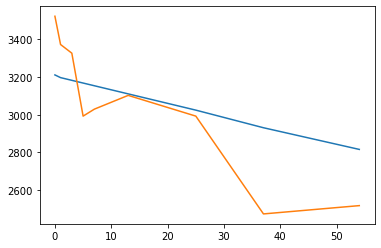

In [35]:
plt.plot(data.weeks, FVC_preds.detach().cpu().numpy())

plt.plot(data.weeks, FVC_true.cpu().numpy())

In [32]:
agg_loss = 0
for FVC, preds in zip(data.fvcs, all_preds):
    coefs = preds[:4]
    log_sigma = preds[4]
#             print(log_sigma.item())

    FVC_preds = (weeks * coefs).sum(dim=1)
    FVC_preds = FVC_preds * FVCs_std + FVCs_mean + 1000 - 200
    FVC_true = torch.tensor(data.fvcs, dtype=dtype)

    agg_loss += LaplaceLossTMP()(FVC_true, FVC_preds, torch.tensor(np.log(70)))
loss = agg_loss / len(data.weeks)

In [33]:
loss

tensor(8.7861, grad_fn=<DivBackward0>)

In [ ]:
log_sigma.item()

In [24]:
from torchsummary import summary

In [26]:
# summary(model.CT_features_extractor[0].net)

In [ ]:
for name, p in model.named_parameters():
    print(f'{name[20:]:50} : {p.data.min().item():15.3e}, {p.data.max().item():15.3e}')

In [13]:
all_preds = model(train_dataset[2])

In [14]:
all_preds

[tensor([-0.0239,  0.0427, -0.0162,  0.0765, -0.0407], grad_fn=<CopyBackwards>),
 tensor([-0.0596,  0.0999,  0.0310,  0.0311, -0.0328], grad_fn=<CopyBackwards>),
 tensor([-0.0534,  0.0610,  0.0263,  0.1096, -0.0509], grad_fn=<CopyBackwards>),
 tensor([-0.0468, -0.0004,  0.0322,  0.0902, -0.0749], grad_fn=<CopyBackwards>),
 tensor([-0.0137,  0.0090,  0.0003,  0.0589, -0.0920], grad_fn=<CopyBackwards>),
 tensor([-0.0302,  0.0220,  0.0029,  0.1146, -0.0387], grad_fn=<CopyBackwards>),
 tensor([-0.0218,  0.0516, -0.0411,  0.0951,  0.0158], grad_fn=<CopyBackwards>),
 tensor([-0.0205,  0.0779, -0.0219,  0.1012, -0.0544], grad_fn=<CopyBackwards>),
 tensor([ 0.0394,  0.0843, -0.0223,  0.0686, -0.0343], grad_fn=<CopyBackwards>)]

In [16]:
data = train_dataset[2]
data_weeks = torch.tensor(data.weeks, dtype=dtype)
weeks = torch.empty(len(data.weeks), 4, dtype=dtype)
weeks[:, 0] = data_weeks ** 3
weeks[:, 1] = data_weeks ** 2
weeks[:, 2] = data_weeks
weeks[:, 3] = 1

# all_preds = model(data)

agg_loss = 0
for week, FVC, preds in zip(data.weeks, data.fvcs, all_preds):
    coefs = preds[:4]
    log_sigma = preds[4]

    FVC_preds = (weeks * coefs).sum(dim=1)
    FVC_true = torch.tensor(data.fvcs, dtype=dtype)

    agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)
loss = agg_loss / len(data.weeks)

In [17]:
loss

tensor(4912.0527, grad_fn=<DivBackward0>)

In [18]:
loss.backward()

In [25]:
for name, p in model.named_parameters():
    if p.requires_grad:
        if p.grad is None:
            print(f'Has grad but it is None: {name[20:]:50}')
        else:
            print(f'{name[20:]:50} : {p.grad.data.cpu().min().item():15.3e}, {p.grad.data.cpu().max().item():15.3e}')
    else:
        print(f'No grad: {name[20:]:50}')

RuntimeError: CUDA error: unspecified launch failure

In [12]:
for i in range(len(train_dataset)):
    print(i, train_dataset[i].images.shape)

In [4]:
dataset_all = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=True, test_size=0.0, random_state=42
)

images = [-1000 * (1.0 - dataset_all[i].masks) + dataset_all[i].masks * dataset_all[i].images
          for i in range(len(dataset_all))]

sum_image = 0
sum_sq_image = 0
for image in images:
    sum_image += image.sum()
    sum_sq_image += (image ** 2).sum()

N = np.prod((176., 192., 256., 256.))

mean = sum_image / N

mean

var = sum_sq_image / N + mean ** 2 - 2 * mean * sum_image / N

std = var ** 0.5

mean, std